In [3]:
%matplotlib inline


# Active Learning on a toy example

In this first notebook, we set up a very basic active learning experiment and realise a benchmark of various query sampling methods. We use the digit recognition task from the scikit-learn package.

For this little study, we will be using the task of digit recognition. We set the parameters of the experiment below.

## Query sampler interface and simple example

Most active learning packages offer a common interface for their samplers, just as scikit-learn offers an interface for all its estimators. For this tutorial, we will work with the base interface proposed by cardinal.

Cardinal samplers are initialized with the `batch_size` and require 2 methods:
- `fit(X, y)` that fits the sampler on already labeled data
- `select_samples(X)` that selected `batch_size` samples from the unlabeled X, and returns their indexes

Here is a skeleton of sampler. The first exerise is to make the simplest sampler that exists: a sampler that always selects the first unlabeled sample.

In [4]:
from cardinal.base import BaseQuerySampler


class DummySampler(BaseQuerySampler):
    
    def fit(self, X, y):
        pass
    
    def select_samples(self, X):
        return np.arange(min(self.batch_size, X.shape[0]))

## My first active learning loop

For this first loop, we will keep things simple. We do a first loop with a simple sampler and without cross-validation. A skeleton of algorithm is proposed to help your design your experiment.

In [5]:
from sklearn.datasets import make_blobs
from sklearn.svm import SVC
import numpy as np


n = 30
batch_size = 2
n_iter = 6

X, y = make_blobs(n_samples=n, centers=2,
                  random_state=0, cluster_std=0.80)

model = SVC(kernel='linear', C=1e10, probability=True)


# Selected samples
# ----------------
# As a start, select the first samples available from each class.

init_idx = [np.where(y == 0)[0][0], np.where(y == 1)[0][0]]

mask = np.zeros(n, dtype=bool)
indices = np.arange(n)
mask[init_idx] = True


# 0 0 0 1 0 1 0 0
# 0 1 2 - 3 - 4 5

# Main active learning loop
# -------------------------
# During an active learning loop, you should:
# - fit the model on already selected samples
# - use the sampler defined before to select new samples
# - integrate those samples in the pool of selected samples
# Remember that your sampler selects the first sample of the unlabaled pool.
# You can therefore sanity check your code by looking at the aboslute index
# of your samples.

sampler = DummySampler(batch_size=batch_size)

for j in range(n_iter):
    model.fit(X[mask], y[mask])
    sampler.fit(X[mask], y[mask])
    selected = sampler.select_samples(X[~mask])
    mask[indices[~mask][selected]] = True
    print('Selected:', indices[~mask][selected])

Selected: [4 5]
Selected: [6 7]
Selected: [8 9]
Selected: [10 11]
Selected: [12 13]
Selected: [14 15]


# Let's get closer to real life!


## Indexing data

It may not seems like it but indexing data in an active learning setting is important. It is even one of the most striking difference between active learning packages that handles it differently. Cardinal proposes a utility object that allows easily train / test split, stored the selected samples for each iteration, but also allows to retrieve them.

It comes with its own vocabulary:
- `train` designates the set of samples to be considered for labeling. It is divided in 2 subsets:
  - `selected` is the set of samples that have been labeled so far
  - `non_selected` is the set of samples that remain to be labeled
- `test` is a left out test set for evaluation

In [4]:
import numpy as np
from cardinal.utils import ActiveLearningSplitter


X_toy = np.arange(10)[:, None]
y_toy = np.arange(10) // 5


idx = ActiveLearningSplitter.train_test_split(X_toy.shape[0], test_size=2, random_state=0)

print('Train', np.where(idx.train)[0])
print('Test ', np.where(idx.test)[0])

Train [0 1 3 4 5 6 7 9]
Test  [2 8]


In this small toy example, we use our Dummy Sampler to add 2 samples to the set of selected samples at each iteration. Note that for now we do not use any model as our query strategy is completely unsupervised.

In [5]:
sampler = DummySampler(batch_size=2)


for i in range(3):
    sampler.fit(X_toy[idx.selected], y_toy[idx.selected])
    selected = sampler.select_samples(X_toy[idx.non_selected])
    idx.add_batch(selected)  # The splitter knows that the indices are from the non_selected samples
    print("Samples selected at iteration {}: {}".format(i, X_toy[idx.non_selected][selected][:, 0]))

Samples selected at iteration 0: [3 4]
Samples selected at iteration 1: [5 6]
Samples selected at iteration 2: [7 9]


The splitter allows to replay the experiment. Methods allow to retrieve indices for specific iterations:
- `batch_at(iteration)`
- `selected_at(iteration)`
- `non_selected_at(iteration)`

In [1]:
print('At iteration 1:')
print('  Selected:', np.where(idx.selected_at(1))[0])
print('  Batch:   ', np.where(idx.batch_at(1))[0])
print('At iteration 2:')
print('  Selected:', np.where(idx.selected_at(2))[0])

At iteration 1:


NameError: name 'np' is not defined

## Preparing the task

For this tutorial, we run our experiment on the digit dataset. In order to visualize it, we offer a function to plot a tSNE representation of it.

The parameters of this experiment are:

* ``batch_size`` is the number of samples that will be annotated and added to
  the training set at each iteration,
* ``n_iter`` is the number of iterations in the simulation.

We use the digits dataset and a RandomForestClassifier.


In [2]:
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from matplotlib import offsetbox
from matplotlib import pyplot as plt


batch_size = 45
n_iter = 10

digits = load_digits()
X, y = load_digits(return_X_y=True)
X /= 255.

idx = ActiveLearningSplitter.train_test_split(X.shape[0], test_size=.2, random_state=0)

model = RandomForestClassifier()

tsne = TSNE()
X_tsne = MinMaxScaler().fit_transform(tsne.fit_transform(X, y))


def plot_digits(name, splitter, it=None):
    plt.figure(figsize=(16, 10))
    ax = plt.gca()

    shown_images = np.array([[1.0, 1.0]])
    X_tsne_train = X_tsne[splitter.train]
    for i, (is_train, is_selected) in enumerate(zip(splitter.train, splitter.selected_at(it))):
        if not is_train:
            continue
        ax.text(
            X_tsne[i, 0],
            X_tsne[i, 1],
            str(y[i]),
            color=plt.cm.tab10(y[i]),
            fontdict={"weight": "bold", "size": 12},
            alpha = 1. if is_selected else 0.15
        )

        # show an annotation box for a group of digits
        dist = np.sum((X_tsne[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X_tsne[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), X_tsne[i]
        )
        ax.add_artist(imagebox)
    ax.set_title(name)
    ax.axis("off")

plot_digits('Test', idx)

NameError: name 'ActiveLearningSplitter' is not defined

## Core Active Learning Experiment

In this notebook and the following, we will use the same experiment structure. It is paramount to take time to get used to it as we will make it grow and it will become more complex in the following exercises. Please take time to read it carefully and understand each step.

In [ ]:
from cardinal.uncertainty import MarginSampler
from cardinal.random import RandomSampler
from cardinal.plotting import plot_confidence_interval


# Samplers

samplers = [
    ('Random', RandomSampler(batch_size)),
    ('Margin', MarginSampler(model, batch_size, assume_fitted=True)),
]

# Here we initialize the matplotlib figure and an index variable that will keep
# track of all the experiment selected samples.

figure_accuracies = plt.figure().number
idxs = {}

for sampler_name, sampler in samplers:
    
    # Keeps track of accuracy over the cross_validation folds of the experiment
    all_accuracies = []

    for k in range(10):
        idx = ActiveLearningSplitter.train_test_split(X.shape[0], test_size=500, random_state=k)

        accuracies = []

        # For simplicity, the first batch is simply one sample from each class
        one_per_class = np.unique(y[idx.non_selected], return_index=True)[1]
        idx.add_batch(one_per_class)

        # Here you recognize the active learning loop coded above
        for j in range(n_iter):
            model.fit(X[idx.selected], y[idx.selected])
            accuracies.append(model.score(X[idx.test], y[idx.test]))
            sampler.fit(X[idx.selected], y[idx.selected])
            idx.add_batch(sampler.select_samples(X[idx.non_selected]))

        all_accuracies.append(accuracies)
    
    # Keep the splitter of the latest experiment since the exercise requires to analyze one iteration.
    idxs[sampler_name] = idx
    
    # Compute the number of samples for the x-axis
    x_data = np.arange(10, batch_size * (n_iter - 1) + 11, batch_size)

    # Load the figure that contains accuracies and plot the result
    plt.figure(figure_accuracies)
    plot_confidence_interval(x_data, all_accuracies, label=sampler_name)

# Fine tune the plot and display it
plt.figure(figure_accuracies)
plt.xlabel('Labeled samples')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

plt.show()

## Analysis (your turn now!)

Just abobe, we have defined a function to plot a tSNE representation of the data. We have also run two different samplers and kept the history of their selected samples. We want now to build our intuition about why Margin sampling is better than Random, just by looking at the selected samples. Plot the selected samples at different iterations and try to understand by yourself!

In order to plot the selected samples for the random sampler at iteration 2, do the following:
`plot_digits('Random', idxs['Random'], it=2)`

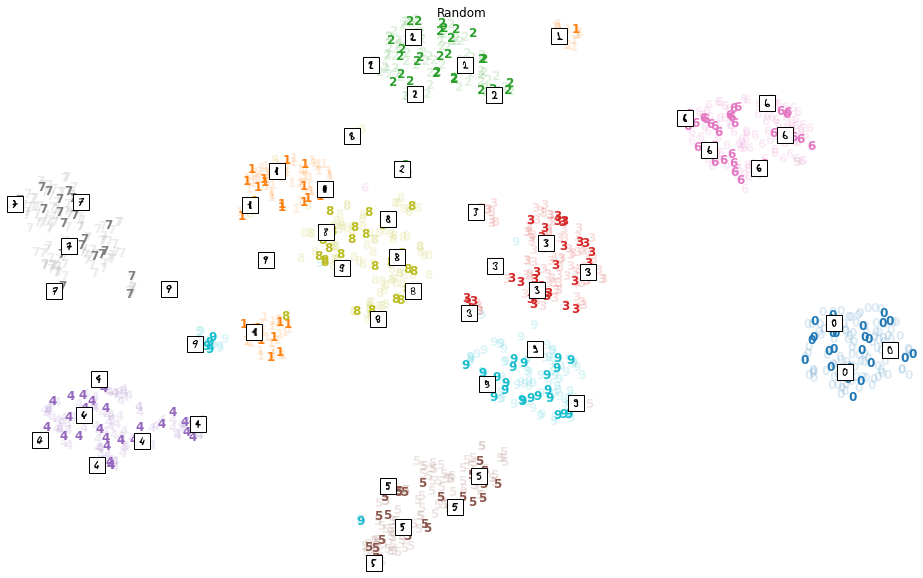

In [49]:
plot_digits('Random', idxs['Random'], it=7)

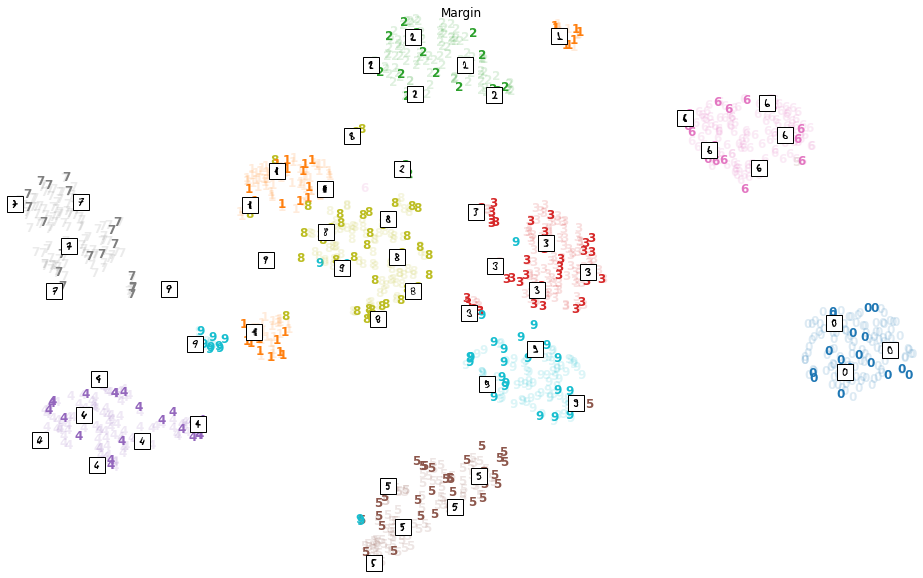

In [50]:
plot_digits('Margin', idxs['Margin'], it=7)